# Basic characterizations of UA Q2
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 1 # for UA Q2
res_index = 1 # for UA Q2
flux_index = 1 # for UA Q2
TLS_index = 0 # for TLS of interest

2024-04-02 09:07:14,659 - qm - INFO     - Starting session: 169ceec8-3ebd-4fdf-83dc-710440187a1e


In [94]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [131]:
# Set all DC bias to 0
for i in np.arange(7):
    val = machine.flux_lines[i].dc_voltage       
    machine.flux_lines[i].dc_voltage -= val
machine = Analysis.set_machine(machine)

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [133]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [51]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-04-02 08:53:31,482 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 08:53:31,493 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-04-02 08:53:39,060 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.195 GHz, -50.000 MHz)
2024-04-02 08:53:52,626 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: 0.000211 V
DC offset to add to Q: 0.000133 V
TOF to add: 0.0 ns


<Figure size 800x400 with 0 Axes>

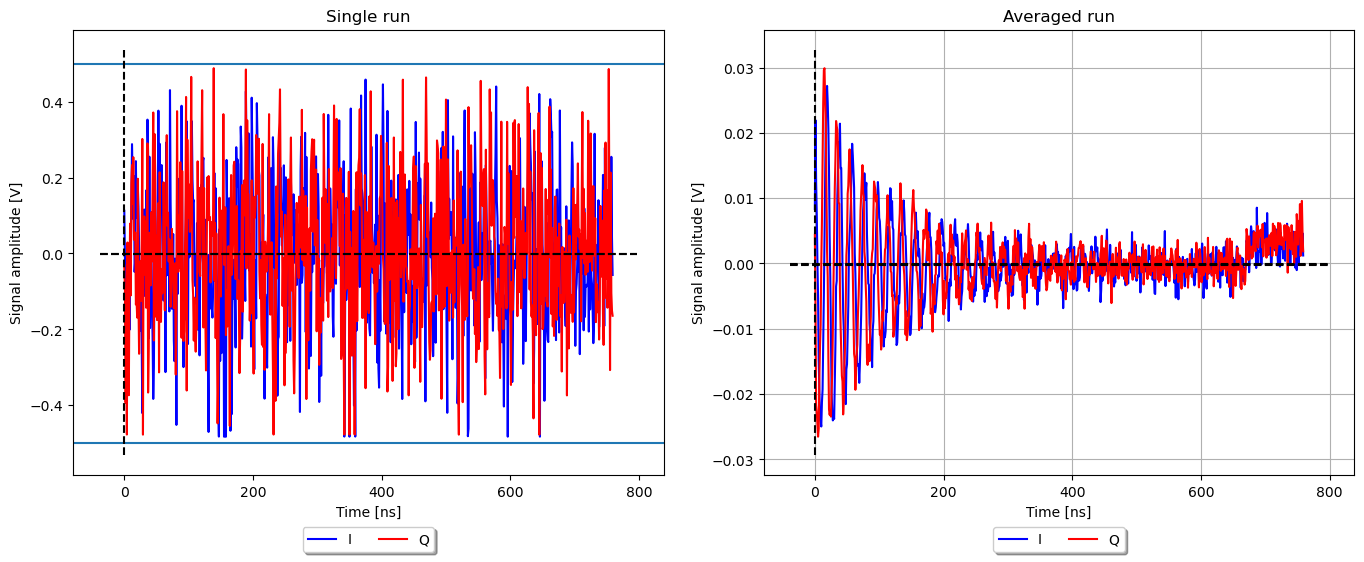

Execution stopped by user!


In [99]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [100]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [143]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.28s


resonator frequency: 7133.077 MHz
Execution stopped by user!


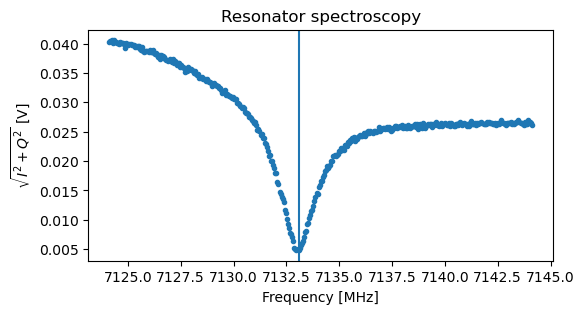

In [144]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [145]:
res_freq_sweep = np.arange(7.127E9,7.137E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                                    n_avg = 1E3, cd_time = 10E3, plot_flag = True)

Progress: [##################################################] 100.0% (n=37/37)


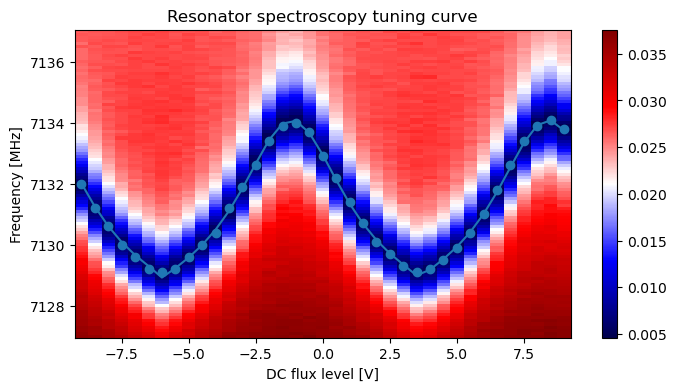

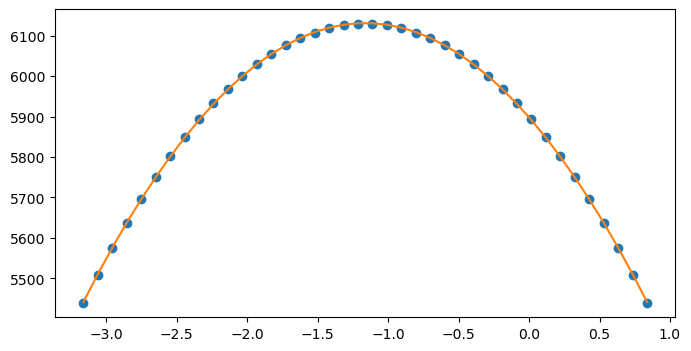

In [147]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [149]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [150]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [151]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 6.03s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 6.08s
resonator frequency: 7134.038 MHz


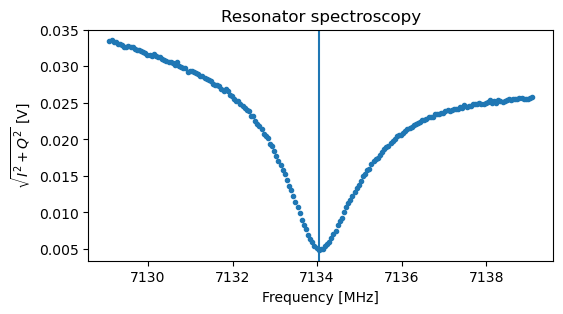

In [152]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [4]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-04-01 17:29:14,767 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-04-01 17:29:14,770 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-01 17:29:14,785 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-04-01 17:29:22,649 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.255 GHz, -50.000 MHz)
2024-04-01 17:29:35,813 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [208]:
if False: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-30E6, 30E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 5E3, cd_time = 30E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 17.30s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 17.34s


resonant frequency: 6195.203 MHz


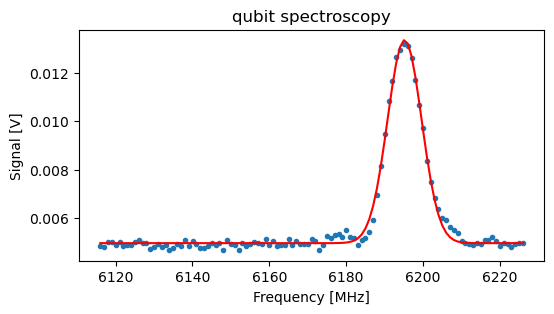

In [210]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

In [211]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-04-03 09:03:36,386 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-03 09:03:36,395 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-04-03 09:03:43,940 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.245 GHz, -50.000 MHz)
2024-04-03 09:03:57,175 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [212]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 40 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 25E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9.47s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9.51s


rabi_pi_pulse: 130.9 ns
half period: 119.71 ns


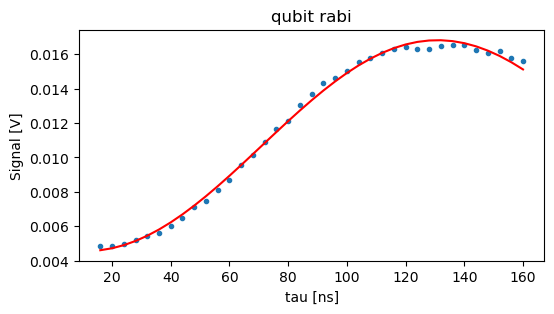

In [213]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [190]:
machine.qubits[qubit_index].pi_length[0] = 100
# machine.qubits[qubit_index].pi_amp[0] = 0.0270983
machine = Analysis.set_machine(machine)

### power rabi

In [214]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.1, 1.5, 0.025) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 40E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 22.89s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 22.94s


rabi_pi_pulse_amp: 0.03653 V
half period: 0.0362931 V


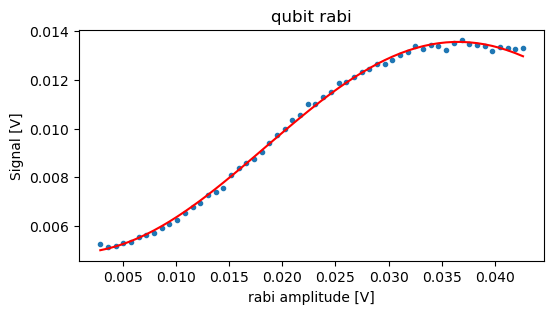

In [215]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [203]:
# machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.item()
machine.qubits[qubit_index].pi_amp[0] = 0.0289
machine = Analysis.set_machine(machine)

## T1

In [169]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,1E3)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 10E3, cd_time = 30E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13.51s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13.56s


Qubit T1 [us]: 3.4313608660185975


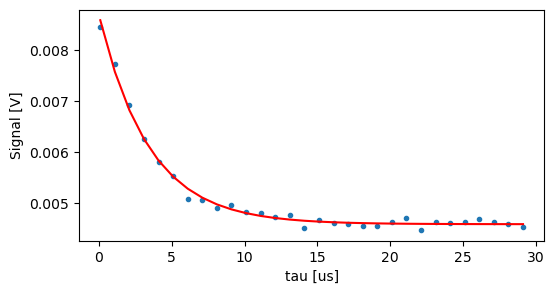

In [170]:
%matplotlib inline
q_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [206]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 2000 + 0.1, 10)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 5E3, detuning = 2E6, cd_time = 20E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 24.82s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 24.95s
Execution stopped by user!


Qubit T2* [ns]: 135.78993189655984
Detuning [MHz]: -0.9784641175504661
Exponent n: 6.630970091156009


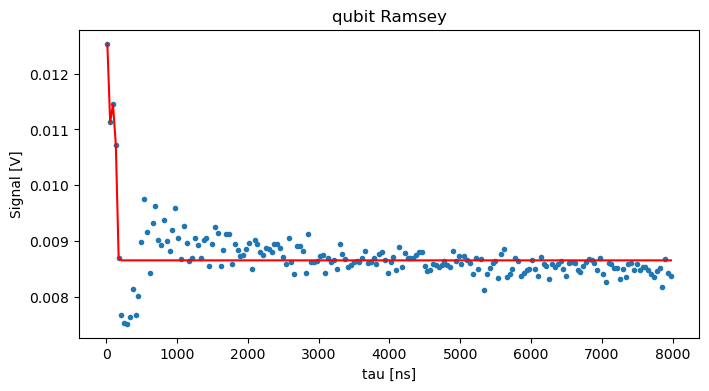

In [207]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-200E6, -150E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [184]:
# The cheat method when the tuning curve is way off
machine.qubits[qubit_index].DC_tuning_curve[2] = 6050
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].DC_tuning_curve[2]*1E6 + 100E6
machine = Analysis.set_machine(machine)

In [45]:
machine = Analysis.get_machine()

In [46]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-04-02 10:53:44,842 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 10:53:44,854 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-04-02 10:53:53,258 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.081 GHz, -50.000 MHz)
2024-04-02 10:54:05,878 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [48]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.4,0.4+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 1E3, cd_time = 30E3, plot_flag = True)

Progress: [##################################################] 100.0% (n=41/41) --> elapsed time: 744.24s


In [49]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -1.17302 V


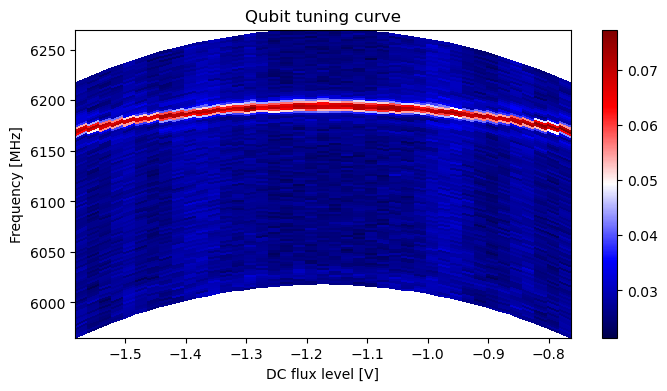

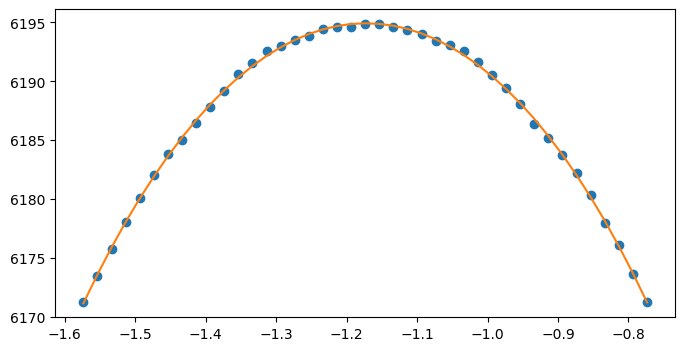

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
E

In [50]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [51]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [47]:
# octave calibration
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 200E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-04-02 10:55:08,246 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 10:55:08,257 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-04-02 10:55:15,777 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.231 GHz, -200.000 MHz)
2024-04-02 10:55:29,263 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [54]:
machine = Analysis.get_machine()

In [55]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.25+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 5.5, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

2024-04-02 11:11:26,657 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 11:11:26,669 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (5.907 GHz, 290.000 MHz)
2024-04-02 11:11:33,015 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-04-02 11:12:18,362 - qm - INFO     - Performing health check.3% (n=5/6) --> elapsed time: 51.75s


INFO:qm.api.frontend_api:Performing health check


2024-04-02 11:12:18,369 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (5.627 GHz, 290.000 MHz)
2024-04-02 11:12:24,596 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=6/6) --> elapsed time: 84.23s


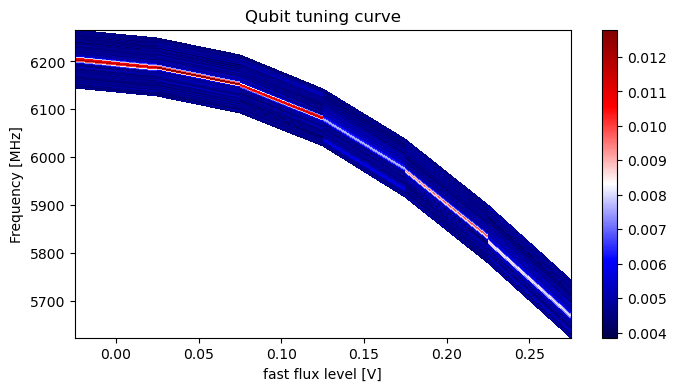

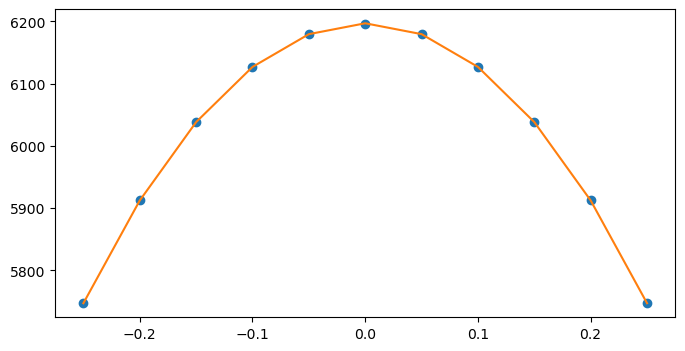

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [56]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [65]:
machine = Analysis.get_machine()

In [66]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4E9, -5E6)
#qubit_freq_sweep = np.arange(q_freq_max,4E9,-100E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 30E3, plot_flag = True)

-------------------------------------some fast flux > 0.5V, removed from experiment run
2024-04-02 11:28:52,818 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 11:28:52,832 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (5.898 GHz, 200.000 MHz)
2024-04-02 11:28:58,356 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.42s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.58s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.52s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.67s
2024-04-02 12:19:48,623 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 12:19:48,636 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (5.698 GHz, 200.000 MHz)
2024-04-02 12:19:55,163 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.43s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.59s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.42s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.58s
2024-04-02 13:10:43,952 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 13:10:43,966 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (5.098 GHz, 200.000 MHz)
2024-04-02 13:10:49,829 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.54s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.69s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.43s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.60s
2024-04-02 14:01:40,244 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 14:01:40,258 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (4.898 GHz, 200.000 MHz)
2024-04-02 14:01:46,208 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.45s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.60s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.47s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.63s
2024-04-02 14:52:35,747 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 14:52:35,777 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (4.298 GHz, 200.000 MHz)
2024-04-02 14:52:41,705 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.51s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1510.66s
2024-04-02 15:18:16,185 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 15:18:16,198 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q1 for (LO, IF) = (4.098 GHz, 200.000 MHz)
2024-04-02 15:18:21,902 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1057.34s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1057.50s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


<Figure size 800x400 with 0 Axes>

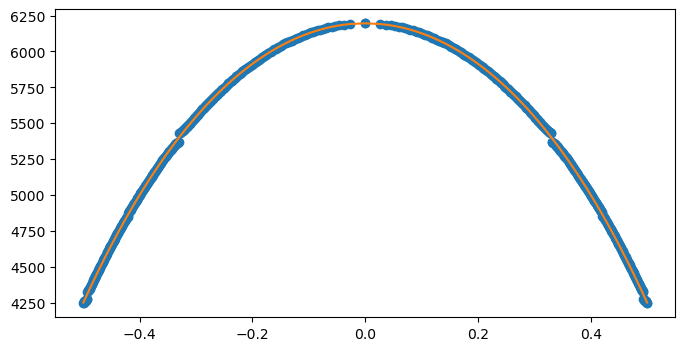

In [67]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
#machine.qubits[qubit_index].AC_tuning_curve = [-4245.549395948013,0.0,-6707.594982241495,0.0,6413.009439410573]
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

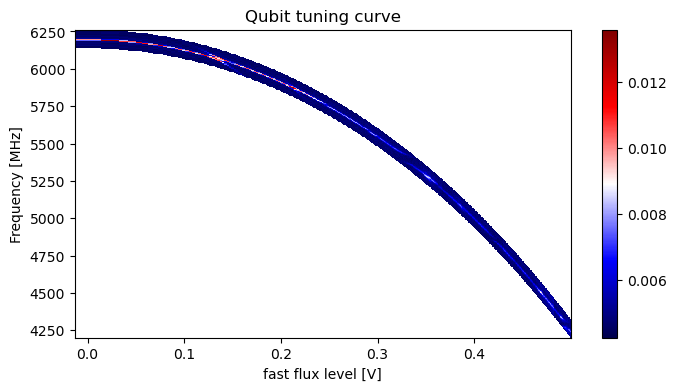

In [68]:
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(ff_sweep_abs, qubit_freq_sweep.T / u.MHz, sig_amp_qubit.T, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# TLS experiments

## TLS SWAP spectroscopy

In [96]:
# Go back to the sweet spot and calibrate
machine.qubits[qubit_index].f_01 = int(np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)) + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [97]:
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-04-02 16:38:05,836 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-02 16:38:05,844 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2024-04-02 16:38:07,801 - qm - WARNING  - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 


2024-04-02 16:38:07,804 - qm - WARNING  - Open QM ended with warning 0: Quantum Machine qm-1712100134010 is canceling running job 1702933256170.


------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-04-02 16:38:14,033 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.246 GHz, -50.000 MHz)
2024-04-02 16:38:27,318 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

In [70]:
%matplotlib qt
tau_sweep_abs = np.arange(16,160 + 0.1,4)
ff_sweep_abs = np.arange(0.1,0.5,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 30E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2320.17s
Execution stopped by user!


### fine, with baking

In [98]:
%matplotlib qt
tau_sweep_abs = np.arange(4,100,1)
ff_sweep_abs = np.arange(0.32,0.34+1E-4,0.0001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 1E3, cd_time = 50E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 1956.11s
Execution stopped by user!


In [112]:
machine.flux_lines[flux_index].iswap.length.append(20)
machine.flux_lines[flux_index].iswap.level.append(0.3298)
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [107]:
machine = Analysis.get_machine()

In [108]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [109]:
print(freq_tls)

[5409.33968157]


In [110]:
TLS_index = 1

In [120]:
%matplotlib qt
tau_sweep_abs = np.arange(100,5000E3+1,1E5)
#tau_sweep_abs = np.logspace(100,2000E3,50,endpoint=True)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 30E3, cd_time_TLS = 10000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!                                   ] 0.1% (n=4/5000.0) --> elapsed time: 1.87s


Qubit T1 [us]: 262.0155768929579


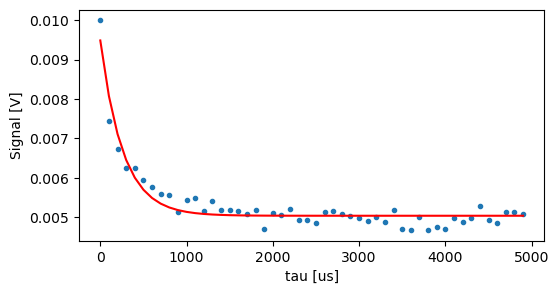

In [128]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [5]:
TLS_index = 0

In [264]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist())) + 0E6
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [265]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine = Analysis.set_machine(machine)

In [266]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-26 16:56:03,128 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-26 16:56:03,136 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-02-26 16:56:10,289 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (5.524 GHz, 200.000 MHz)
2024-02-26 16:56:22,998 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [267]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-70E6,70E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 200E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 31.05s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 31.12s


resonant frequency: 5757.625 MHz


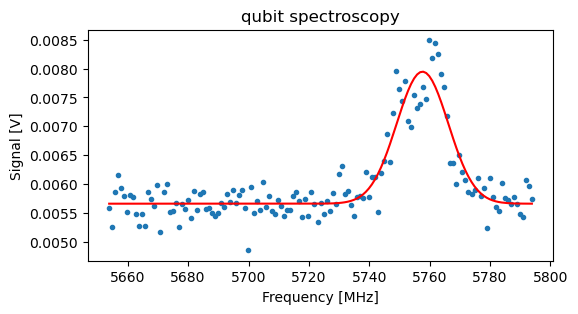

In [269]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)